In [46]:
from __future__ import print_function
import os
import neat

import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt



from explaneat.core.backprop import NeatNet
from explaneat.core import backprop
from explaneat.core.backproppop import BackpropPopulation
from explaneat.visualization import visualize
from explaneat.core.experiment import ExperimentReporter
from explaneat.core.utility import one_hot_encode


from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score



from copy import deepcopy

import time
from datetime import datetime


import gzip
try:
    import cPickle as pickle  # pylint: disable=import-error
except ImportError:
    import pickle  # pylint: disable=import-error

In [43]:

USE_CUDA = torch.cuda.is_available()
USE_CUDA = False
device = torch.device("cuda:1" if USE_CUDA else "cpu")
cuda_device = torch.device("cuda:1")

# Breast Cancer Experiment

This experiment (a) test the experimental environment, but is also to evaluate the efficacy of the ExplaNEAT algorithm. Speed is a critical factor, as well as stability of results on population size. Total run time will also be measured

First, we need to set a random seed and a total stopping point in the number of generations

In [3]:
my_random_seed = 42
random.seed(my_random_seed)

In [4]:
def one_hot_encode(vals):
    width = max(vals)
    newVals = []
    for val in vals:
        blank = [0. for _ in range(width + 1)]
        blank[val] = 1.
        newVals.append(blank)
    return np.asarray(newVals)


## Dataset

We are going to work with the Iris dataset, which will be loaded from `sklearn`. We want to characterise the efficacy of the algorithm with regards to a mostly untransformed dataset, so we will only normalise the features

In [544]:
def load_dataset(fp, 
                 randomSeed = 42, 
                 proportionValidation = 0.2,
                scale = True):
    ''' Takes in a filepath, returns x_train, x_validate, y_train, y_validate'''
    df = pd.read_csv(fp).reset_index(drop=True)
    xs_raw = df[[
        'ag_age',
        'ag_sex',
        'ag_eth',
        'pt_nzdep',
        'imp_hxdiab',
        'pt_tc_hdl_ratio',
        'pt_bps',
        'pt_bpd',
        'pt_smoke',
        'imp_hxcvd',
        'imp_hdl',
        'imp_ldl',
        'imp_tchol',
        'marker',
        'region',
        'PH_BL_LLD_ANY',
        'PH_BL_AHT_ANY',
        'pt_familyhistory',
        'ab_gen',
        'eth_gen',
        'is.female',
        'log.age',
        'log.age.gender',
        'log.sbp',
        'smoking',
        'log.tchdl',
        'diabetes',
        'diabetes.sex']]
    
    xs_raw = xs_raw[[
        'is.female', 
        'ag_age',
        'pt_bps',
        'smoking',
        'pt_tc_hdl_ratio',
        'diabetes'
    ]]


    if scale:
        scaler = StandardScaler()

        scaler.fit(xs_raw)
        xs = scaler.transform(xs_raw)
    else:
        xs = xs_raw
    ys = df['dead'].apply(lambda x: 1 if x else 0)
    ys = np.array(ys).astype(float)
    if proportionValidation == 0:
        return xs, [], ys, []
    X_train, X_validate, y_train, y_validate = train_test_split(xs, ys, test_size=proportionValidation, random_state=randomSeed)
    return X_train, X_validate, y_train, y_validate
    


In [6]:
datasetLocation = './../../data/processed/synthetic_view/'
datasetFileTemplate = 'synthetic_view_test_{:07d}.csv'


In [785]:
# datasetSize = 5000
# datasetSize = 1000
# datasetSize = 2500
# datasetSize = 5000
# datasetSize = 10000
datasetSize = 25000


In [786]:
X_train, X_test, y_train, y_test = load_dataset(os.path.join(datasetLocation, datasetFileTemplate.format(datasetSize)))


In [787]:
X_validate, _ , y_validate, _ = load_dataset(os.path.join(datasetLocation, 'synthetic_view_test.csv'), proportionValidation = 0)

## Performance metric

The NEAT implementation on which ExplaNEAT extends uses a single function call for evaluating fitness. Although this might be reworked for ExplaNEAT to be able to get consistency between the genome-evaluation and the backprop loss function, that can be reviewed later.

This use `Binary Cross Entropy Loss` from `PyTorch`

In [788]:
def eval_genomes(genomes, config):
    loss = nn.BCELoss()
    loss = loss.to(device)
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        preds = []
        for xi in X_train:
            preds.append(net.activate(xi))
        genome.fitness = float(1./loss(torch.tensor(preds).to(device), torch.tensor(y_train)))

## The competition

In [789]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);


In [790]:
# Use the forest's predict method on the test data
rf_preds = rf.predict(X_validate)
# Calculate the absolute errors
errors = abs(rf_preds - y_validate)

In [791]:
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.12


In [792]:
abs(rf_preds.round(0) - y_validate)

array([0., 0., 0., ..., 0., 0., 0.])

In [793]:
errors

array([0.003, 0.107, 0.193, ..., 0.005, 0.052, 0.017])

In [794]:
# Importing the classification report and confusion matrix
print(confusion_matrix(y_validate,rf_preds.round(0)))

[[418272   2076]
 [ 30091    839]]


In [795]:
rf_preds[:5]

array([0.003, 0.107, 0.193, 0.015, 0.064])

In [796]:
roc_auc_score(y_validate, rf_preds)


0.7411638588704224

## SVM

In [797]:
from sklearn.svm import SVC
# svm_model=SVC()


In [798]:
# svm_model.fit(X_train, y_train)
# svm_preds=svm_model.predict(X_validate)
# print(confusion_matrix(y_test,pred))

In [799]:
# Importing the classification report and confusion matrix
# print(confusion_matrix(y_validate,svm_preds))

In [800]:
# print(confusion_matrix(y_train, svm_model.predict(X_train).round(0)))

In [801]:
# roc_auc_score(y_validate, svm_preds)

In [802]:
# kernels = ['linear', 'rbf', 'poly']
# for kernel in kernels:
#     svm_model = SVC(kernel=kernel).fit(X_train, y_train)
#     svm_model.fit(X_train, y_train)
#     svm_preds=svm_model.predict(X_test)
#     print(roc_auc_score(y_test, svm_preds))

In [803]:
# gammas = [0.1, 1, 10, 100]
# for gamma in gammas:
#     for kernel in kernels:
#         svm_model = SVC(kernel=kernel, gamma=gamma).fit(X_train, y_train)
#         svm_model.fit(X_train, y_train)
#         svm_preds=svm_model.predict(X_test)
#         print(roc_auc_score(y_test, svm_preds))

In [804]:
# cs = [0.1, 1, 10, 100, 1000]
# kernel='rbf'
# gamma=1
# for c in cs:
#     svm_model = SVC(kernel=kernel, gamma=gamma, C=c).fit(X_train, y_train)
#     svm_model.fit(X_train, y_train)
#     svm_preds=svm_model.predict(X_test)
#     print(roc_auc_score(y_test, svm_preds))

In [805]:
# degrees = [0, 1, 2, 3, 4, 5, 6]
# kernel='poly'
# gamma=1
# c = 100
# for degree in degrees:
#     svm_model = SVC(kernel=kernel, gamma=gamma, C=c, degree=degree).fit(X_train, y_train)
#     svm_model.fit(X_train, y_train)
#     svm_preds=svm_model.predict(X_test)
#     print(roc_auc_score(y_test, svm_preds))

# Regression

In [806]:
from sklearn.linear_model import LinearRegression
regression_model=LinearRegression()

In [807]:
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [808]:
regression_preds=regression_model.predict(X_validate)

In [809]:
# Importing the classification report and confusion matrix
print(confusion_matrix(y_validate,regression_preds.round(0)))

[[420348      0]
 [ 30930      0]]


In [810]:
print(confusion_matrix(y_train, regression_model.predict(X_train).round(0)))

[[18642     0]
 [ 1358     0]]


In [811]:
roc_auc_score(y_validate, regression_preds)

0.7901600070160025

# NNs

In [812]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_width=64):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_width) 
        self.fc2 = nn.Linear(hidden_width, hidden_width)
        self.fc3 = nn.Linear(hidden_width, hidden_width)
        self.fc4 = nn.Linear(hidden_width, hidden_width)
        self.fc5 = nn.Linear(hidden_width, output_size)  
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out
class TabularDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, xs, ys):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.xs = xs
        self.ys = ys

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return (x, y)
    


In [813]:
batch_size = 1000
learning_rate = 0.0005
num_epochs = 200

In [814]:
X_train.shape

(20000, 6)

In [815]:
y_train.shape

(20000,)

In [816]:
train_data = TabularDataset(X_train, y_train)
train_loader = DataLoader(train_data, 
                           batch_size=batch_size, 
                           shuffle=True)

validate_data = TabularDataset(X_validate, y_validate)
validate_loader = DataLoader(dataset = validate_data,
                             batch_size=batch_size, 
                             shuffle=False)

total_step = len(train_loader)

my_random_seed = 42
random.seed(my_random_seed)
nn_model = NeuralNet(6, 1).to(cuda_device)

criterion = nn.BCEWithLogitsLoss().to(cuda_device)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)  
for epoch in range(num_epochs):
    for i, (xsnn, ysnn) in enumerate(train_loader):  
        # Move tensors to the configured device
        xsnn = xsnn.float().to(cuda_device)
        ysnn = ysnn.view(-1, 1).float().to(cuda_device)

        # Forward pass
        outputs = nn_model(xsnn)
        train_loss = criterion(outputs, ysnn)
        

        # Backward and optimize
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        if (epoch+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, train_loss.item()))


Epoch [50/200], Step [1/20], Loss: 0.1999
Epoch [50/200], Step [2/20], Loss: 0.2222
Epoch [50/200], Step [3/20], Loss: 0.2289
Epoch [50/200], Step [4/20], Loss: 0.1908
Epoch [50/200], Step [5/20], Loss: 0.2103
Epoch [50/200], Step [6/20], Loss: 0.1909
Epoch [50/200], Step [7/20], Loss: 0.2332
Epoch [50/200], Step [8/20], Loss: 0.1921
Epoch [50/200], Step [9/20], Loss: 0.2007
Epoch [50/200], Step [10/20], Loss: 0.2259
Epoch [50/200], Step [11/20], Loss: 0.2296
Epoch [50/200], Step [12/20], Loss: 0.2035
Epoch [50/200], Step [13/20], Loss: 0.1995
Epoch [50/200], Step [14/20], Loss: 0.2339
Epoch [50/200], Step [15/20], Loss: 0.1940
Epoch [50/200], Step [16/20], Loss: 0.2202
Epoch [50/200], Step [17/20], Loss: 0.2126
Epoch [50/200], Step [18/20], Loss: 0.2096
Epoch [50/200], Step [19/20], Loss: 0.1987
Epoch [50/200], Step [20/20], Loss: 0.1802
Epoch [100/200], Step [1/20], Loss: 0.2121
Epoch [100/200], Step [2/20], Loss: 0.1931
Epoch [100/200], Step [3/20], Loss: 0.2004
Epoch [100/200], Ste

In [817]:
criterion(outputs, ysnn)

tensor(0.2106, device='cuda:1', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [818]:
X_test

array([[-1.04744427, -0.60345721, -0.62139147,  1.15369074,  1.79270771,
        -0.29504415],
       [ 0.95470473, -0.94981522, -1.49473907,  1.15369074,  0.18855711,
        -0.29504415],
       [ 0.95470473,  0.26672526,  0.15300063, -0.86678341, -0.02446268,
        -0.29504415],
       ...,
       [ 0.95470473, -0.96508506, -0.02342771, -0.86678341, -0.53990449,
        -0.29504415],
       [ 0.95470473,  1.26253408,  0.69931284,  1.15369074, -0.84042761,
        -0.29504415],
       [ 0.95470473,  0.0736988 , -1.320091  ,  1.15369074,  0.00772249,
        -0.29504415]])

In [819]:
nn_preds = torch.sigmoid( nn_model.forward(torch.from_numpy(X_test).float().to(cuda_device)).to(device)).detach().numpy()

In [820]:
nn_roc_score = roc_auc_score(y_test, nn_preds)
nn_roc_score

0.7464633634060391

# ExplaNEAT

In [821]:
bestROC = 0
bestTest = -1

for modelNo in range(5):
    filePath = './../../data/experiments/synthview/experiment-dataset-{}-{}/fullStatus.xplnt'.format(datasetSize, modelNo)
    with gzip.open(filePath, 'rb') as f: 
        data = pickle.load(f)     

    p, g, ancestry, ancestors, randomState = data
    config = p.config
    bestNet = neat.nn.FeedForwardNetwork.create(g, config)

    explaneat_preds = [bestNet.activate(x)[0] for x in X_test]
    roc_score = roc_auc_score(y_test, explaneat_preds)
    if roc_score > bestROC:
        bestROC = roc_score
        bestTest = modelNo
    print("Iteration %s ROC: %s" % (modelNo, roc_score))
    
print("Best iteration %s ROC: %s" % (bestTest, bestROC))

Iteration 0 ROC: 0.7673272812299864
Iteration 1 ROC: 0.765755929661045
Iteration 2 ROC: 0.7793690929545227
Iteration 3 ROC: 0.7594298310139725
Iteration 4 ROC: 0.765857973607554
Best iteration 2 ROC: 0.7793690929545227


In [822]:
g.size()

(6, 14)

In [823]:
print(g)

Key: 2296
Fitness: 4.505317211151123
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.8312445878982544, response=1.0, activation=sigmoid, aggregation=sum)
	37 DefaultNodeGene(key=37, bias=0.9964136481285095, response=1.0, activation=sigmoid, aggregation=sum)
	75 DefaultNodeGene(key=75, bias=-0.07918635755777359, response=1.0, activation=sigmoid, aggregation=sum)
	147 DefaultNodeGene(key=147, bias=1.195664882659912, response=1.0, activation=sigmoid, aggregation=sum)
	394 DefaultNodeGene(key=394, bias=-0.003838662290945649, response=1.0, activation=sigmoid, aggregation=sum)
	858 DefaultNodeGene(key=858, bias=0.536012589931488, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-6, 147), weight=0.9302268624305725, enabled=True)
	DefaultConnectionGene(key=(-5, 147), weight=0.5855859518051147, enabled=False)
	DefaultConnectionGene(key=(-5, 858), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(-4, 147), weight=1.0, enabled=True)
	DefaultConnectionGene(k

In [824]:
g.nodes

{0: <neat.genes.DefaultNodeGene at 0x7f7cac41f0b8>,
 37: <neat.genes.DefaultNodeGene at 0x7f7cac41f0f0>,
 75: <neat.genes.DefaultNodeGene at 0x7f7cac41f128>,
 147: <neat.genes.DefaultNodeGene at 0x7f7cac41f160>,
 394: <neat.genes.DefaultNodeGene at 0x7f7cac41f198>,
 858: <neat.genes.DefaultNodeGene at 0x7f7cac41f1d0>}

In [825]:
g.connections

{(-2, 0): <neat.genes.DefaultConnectionGene at 0x7f7cac42ecc0>,
 (-3, 37): <neat.genes.DefaultConnectionGene at 0x7f7cac42ecf8>,
 (37, 0): <neat.genes.DefaultConnectionGene at 0x7f7cac42ed30>,
 (75, 0): <neat.genes.DefaultConnectionGene at 0x7f7cac42ed68>,
 (-4, 147): <neat.genes.DefaultConnectionGene at 0x7f7cac42eda0>,
 (147, 0): <neat.genes.DefaultConnectionGene at 0x7f7cac42edd8>,
 (-6, 147): <neat.genes.DefaultConnectionGene at 0x7f7cac42ee10>,
 (-1, 37): <neat.genes.DefaultConnectionGene at 0x7f7cac42ee48>,
 (-3, 75): <neat.genes.DefaultConnectionGene at 0x7f7cac42ee80>,
 (-2, 394): <neat.genes.DefaultConnectionGene at 0x7f7cac42eeb8>,
 (394, 75): <neat.genes.DefaultConnectionGene at 0x7f7cac42eef0>,
 (-5, 147): <neat.genes.DefaultConnectionGene at 0x7f7cac42ef28>,
 (37, 147): <neat.genes.DefaultConnectionGene at 0x7f7cac42ef60>,
 (-5, 858): <neat.genes.DefaultConnectionGene at 0x7f7cac42ef98>,
 (858, 147): <neat.genes.DefaultConnectionGene at 0x7f7cac42efd0>,
 (75, 858): <neat.g

In [826]:
print(datasetSize)

25000


In [827]:
print(g)

Key: 2296
Fitness: 4.505317211151123
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.8312445878982544, response=1.0, activation=sigmoid, aggregation=sum)
	37 DefaultNodeGene(key=37, bias=0.9964136481285095, response=1.0, activation=sigmoid, aggregation=sum)
	75 DefaultNodeGene(key=75, bias=-0.07918635755777359, response=1.0, activation=sigmoid, aggregation=sum)
	147 DefaultNodeGene(key=147, bias=1.195664882659912, response=1.0, activation=sigmoid, aggregation=sum)
	394 DefaultNodeGene(key=394, bias=-0.003838662290945649, response=1.0, activation=sigmoid, aggregation=sum)
	858 DefaultNodeGene(key=858, bias=0.536012589931488, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-6, 147), weight=0.9302268624305725, enabled=True)
	DefaultConnectionGene(key=(-5, 147), weight=0.5855859518051147, enabled=False)
	DefaultConnectionGene(key=(-5, 858), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(-4, 147), weight=1.0, enabled=True)
	DefaultConnectionGene(k

In [828]:
0, 33, 84, 173, 693, -6

(0, 33, 84, 173, 693, -6)

In [829]:
filePath = './../../data/experiments/synthview/experiment-dataset-{}-{}/fullStatus.xplnt'.format(datasetSize, bestTest)
with gzip.open(filePath, 'rb') as f: 
    data = pickle.load(f)     
    
p, g, ancestry, ancestors, randomState = data
config = p.config
bestNet = neat.nn.FeedForwardNetwork.create(g, config)

explaneat_preds = [bestNet.activate(x)[0] for x in X_validate]

In [830]:
roc_auc_score(y_validate, explaneat_preds)

0.7733603063809082

In [831]:
def calculate_max_depth(genome):
    connections = {}
    def my_depth(connections, ix):
        if ix < 0:
            return 0
        depths = []
        for c in connections[ix]:
            depths.append(my_depth(connections, c))
        return max(depths) + 1
                
    for key, conn in  genome.connections.items():
        if not key[1] in connections:
            connections[key[1]] = []
        connections[key[1]].append(key[0])
    all_depths = {}
    for c in connections:
        all_depths[c] = my_depth(connections, c)
    return all_depths
print("%s & %s & %s" % (g.size()[0]-1, g.size()[1], calculate_max_depth(g)[0]-1))
print(g.size())
print(calculate_max_depth(g))
print(datasetSize)

7 & 19 & 4
(8, 19)
{0: 5, 103: 1, 33: 4, 173: 2, 137: 1, 84: 3, 693: 1, 827: 1}
25000


In [832]:
def check_input_connections(genome, config):
    n_inputs = config.genome_config.num_inputs
    checks = {-n: False for n in range(1, n_inputs+1)}
    for c in genome.connections:
        if c[0] < 0:
            checks[c[0]] = True
    print(checks)
    mySum = 0
    for k, v in checks.items():
        if v: 
            mySum += 1
    return mySum
check_input_connections(g, config)

        

{-1: True, -2: True, -3: True, -4: True, -5: True, -6: True}


6

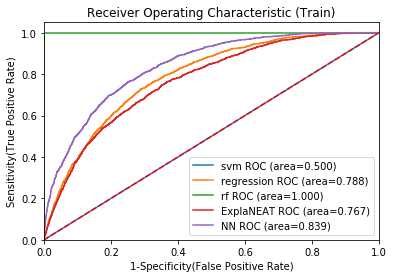

In [833]:
train_preds = {
    'svm': svm_model.predict(X_train),
    'regression': regression_model.predict(X_train),
    'rf': rf.predict(X_train),
    'ExplaNEAT': [bestNet.activate(x)[0] for x in X_train],
    'NN': torch.sigmoid( nn_model.forward(torch.from_numpy(X_train).float().to(cuda_device)).to(device)).detach().numpy()
}

plt.figure()
for model, preds in train_preds.items():
    fpr, tpr, thresholds = metrics.roc_curve(y_train, preds)
    auc = metrics.roc_auc_score(y_train, preds)
    plt.plot(fpr, tpr, label='%s ROC (area=%0.3f)' % (model, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Train)')
plt.legend(loc="lower right")
plt.show()   # Display

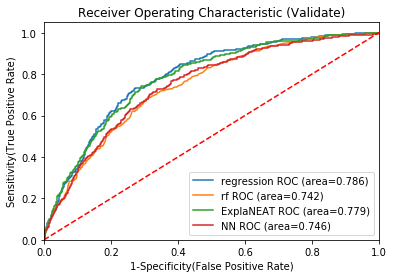

In [933]:
test_preds = {
#     'svm': svm_model.predict(X_test),
    'regression': regression_model.predict(X_test),
    'rf': rf.predict(X_test),
    'ExplaNEAT': [bestNet.activate(x)[0] for x in X_test],
    'NN': torch.sigmoid( nn_model.forward(torch.from_numpy(X_test).float().to(cuda_device)).to(device)).detach().numpy()
}

plt.figure()
for model, preds in test_preds.items():
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr, tpr, label='%s ROC (area=%0.3f)' % (model, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Validate)')
plt.legend(loc="lower right")
plt.show()   # Display

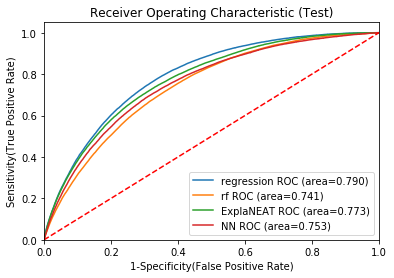

In [934]:
nn_valid_preds = torch.sigmoid( nn_model.forward(torch.from_numpy(X_validate).float().to(cuda_device)).to(device)).detach().numpy()
all_preds = {
#     'svm': svm_preds,
    'regression': regression_preds,
    'rf': rf_preds,
    'ExplaNEAT': explaneat_preds,
    'NN': nn_valid_preds
}

plt.figure()
for model, preds in all_preds.items():
    fpr, tpr, thresholds = metrics.roc_curve(y_validate, preds)
    auc = metrics.roc_auc_score(y_validate, preds)
    plt.plot(fpr, tpr, label='%s ROC (area=%0.3f)' % (model, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Test)')
plt.legend(loc="lower right")
plt.show()   # Display

In [836]:
for model, preds in all_preds.items():
    print(model)
    print(len(preds))
    print(metrics.roc_auc_score(y_validate, preds))

regression
451278
0.7901600070160025
rf
451278
0.7411638588704224
ExplaNEAT
451278
0.7733603063809082
NN
451278
0.7532374024498864


In [837]:
datasetSize

25000

In [838]:
for model, preds in train_preds.items():
    print(model)
    print(metrics.roc_auc_score(y_train, preds))

svm
0.5
regression
0.7878331965809859
rf
1.0
ExplaNEAT
0.7672920617750881
NN
0.8385903590148079


In [839]:
print(g)

Key: 1807
Fitness: 4.506730079650879
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.326330304145813, response=1.0, activation=sigmoid, aggregation=sum)
	33 DefaultNodeGene(key=33, bias=0.9142535924911499, response=1.0, activation=sigmoid, aggregation=sum)
	84 DefaultNodeGene(key=84, bias=0.25485798716545105, response=1.0, activation=sigmoid, aggregation=sum)
	103 DefaultNodeGene(key=103, bias=1.0926134586334229, response=1.0, activation=sigmoid, aggregation=sum)
	137 DefaultNodeGene(key=137, bias=0.7891878485679626, response=1.0, activation=sigmoid, aggregation=sum)
	173 DefaultNodeGene(key=173, bias=0.10554897785186768, response=1.0, activation=sigmoid, aggregation=sum)
	693 DefaultNodeGene(key=693, bias=0.5955349206924438, response=1.0, activation=sigmoid, aggregation=sum)
	827 DefaultNodeGene(key=827, bias=0.03012346476316452, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-6, 103), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(-6, 173)

In [856]:
X_validate.transpose()[1].max()

2.315971522037532

In [857]:
X_validate.transpose()[1].min()

-1.6415960819310607

In [870]:
print('is.female between %s & %s' % (X_validate.transpose()[0].min(), X_validate.transpose()[0].max()))
print('age between %s & %s' % (X_validate.transpose()[1].min(), X_validate.transpose()[1].max()))
print('pressure between %s & %s' % (X_validate.transpose()[2].min(), X_validate.transpose()[2].max()))
print('smoking between %s & %s' % (X_validate.transpose()[3].min(), X_validate.transpose()[3].max()))
print('ratio between %s & %s' % (X_validate.transpose()[4].min(), X_validate.transpose()[4].max()))
print('diabetes between %s & %s' % (X_validate.transpose()[5].min(), X_validate.transpose()[5].max()))

is.female between -1.0466044760968594 & 0.9554707846552857
age between -1.6415960819310607 & 2.315971522037532
pressure between -3.7789496346594507 & 4.598532506481258
smoking between -0.8659319336215364 & 1.1548251787155581
ratio between -2.3742925914190076 & 4.866205423332583
diabetes between -0.30184140077332805 & 3.3129981421964168


In [869]:
X_validate_raw.std()

is.female           0.499482
ag_age             13.897312
pt_bps             18.320600
smoking             0.494865
pt_tc_hdl_ratio     1.211998
diabetes            0.276638
preds               0.109791
dead                0.252668
pred_bin           10.803739
dtype: float64

In [872]:
X_validate_raw.mean()

is.female            0.522760
ag_age              52.813931
pt_bps             129.232548
smoking              0.428519
pt_tc_hdl_ratio      3.935634
diabetes             0.083501
preds                0.081652
dead                 0.068539
pred_bin             6.025886
dtype: float64

In [548]:
eneat_validate_preds = [bestNet.activate(x)[0] for x in X_validate]

In [545]:
X_validate_raw, _ , y_validate_raw, _ = load_dataset(os.path.join(datasetLocation, 'synthetic_view_test.csv'), proportionValidation = 0, scale=False)

In [549]:
X_validate_raw['preds'] = eneat_validate_preds

In [551]:
import seaborn as sns

In [553]:
X_validate_raw.head()

,is.female,ag_age,pt_bps,smoking,pt_tc_hdl_ratio,diabetes,preds
0,True,35.999047,111.750236,False,3.194507,False,0.005605
1,False,56.171889,133.966593,True,2.018149,False,0.089174
2,True,81.058020,147.440092,False,3.860158,False,0.133893
3,False,33.614260,102.924866,True,3.910955,False,0.023671
4,True,63.126998,119.746439,True,3.971945,False,0.095130


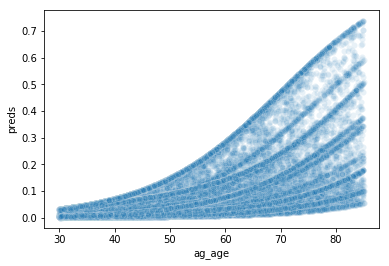

In [561]:
sns.scatterplot(data=X_validate_raw.sample(frac=0.1),
                x='ag_age', 
                y='preds',
               alpha=0.1)

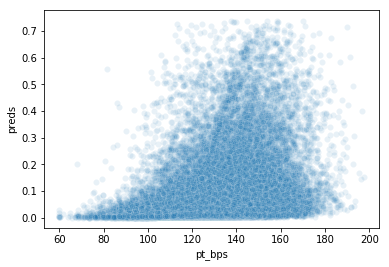

In [562]:
sns.scatterplot(data=X_validate_raw.sample(frac=0.1),
                x='pt_bps', 
                y='preds',
               alpha=0.1)

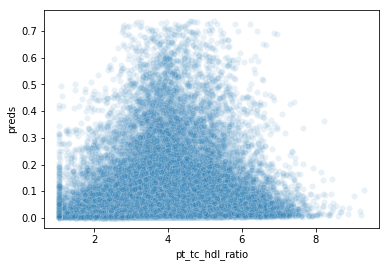

In [563]:
sns.scatterplot(data=X_validate_raw.sample(frac=0.1),
                x='pt_tc_hdl_ratio', 
                y='preds',
               alpha=0.1)

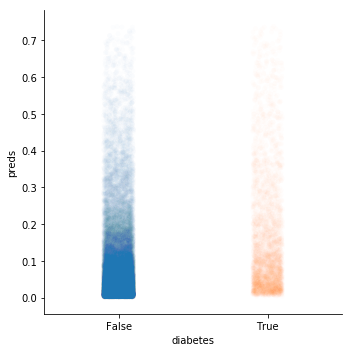

In [573]:
sns.catplot(x="diabetes", 
            y="preds", 
            alpha=0.01,
            data=X_validate_raw.sample(frac=0.1));

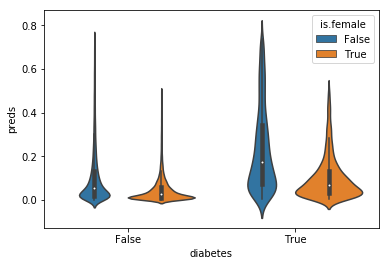

In [578]:
sns.violinplot(x='diabetes', 
               y='preds',
               data=X_validate_raw.sample(frac=0.1), 
               hue='is.female')

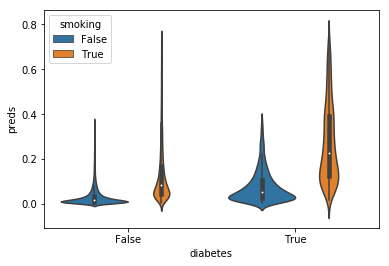

In [579]:
sns.violinplot(x='diabetes', 
               y='preds',
               data=X_validate_raw.sample(frac=0.1), 
               hue='smoking')

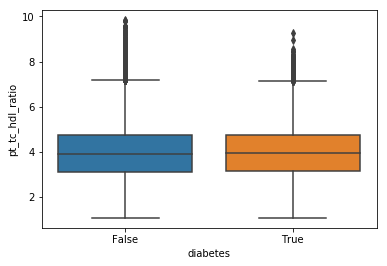

In [661]:
sns.boxplot(x='diabetes', 
               y='pt_tc_hdl_ratio',
               data=X_validate_raw)

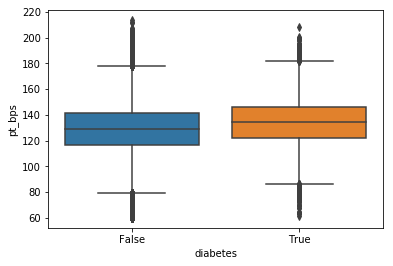

In [674]:
sns.boxplot(x='diabetes', 
               y='pt_bps',
               data=X_validate_raw)

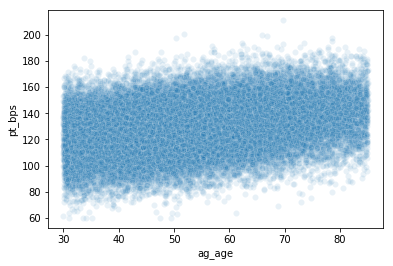

In [669]:
sns.scatterplot(x='ag_age', 
               y='pt_bps',
               data=X_validate_raw.sample(frac=0.1),
               alpha=0.1)

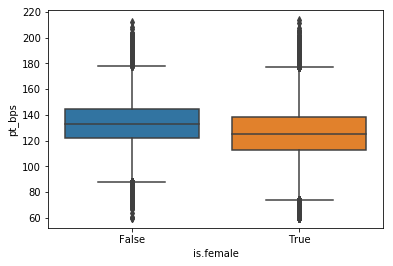

In [667]:
sns.boxplot(x='is.female', 
               y='pt_bps',
               data=X_validate_raw)

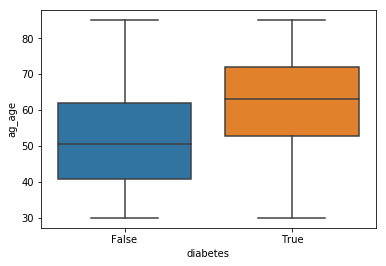

In [664]:
sns.boxplot(x='diabetes', 
               y='ag_age',
               data=X_validate_raw)

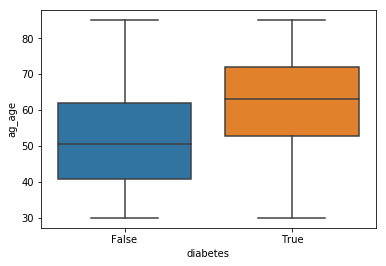

In [664]:
sns.boxplot(x='diabetes', 
               y='ag_age',
               data=X_validate_raw)

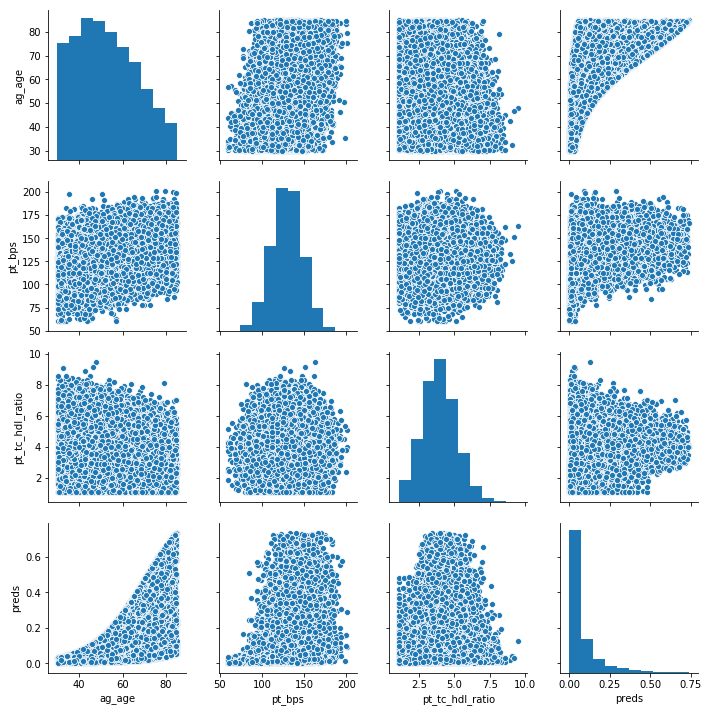

In [584]:
sns.pairplot(X_validate_raw.sample(frac=0.1)[['ag_age','pt_bps','pt_tc_hdl_ratio','preds']])

In [585]:
X_validate_raw['dead'] = y_validate_raw

In [600]:
X_validate_raw['pred_bin'] = X_validate_raw['preds']//0.05*5

In [ ]:
from sklearn.calibration import calibration_curve


In [628]:
nBinsCalib = 10
calibStrategy = 'quantile'
eneat_calib_y, eneat_calib_x = calibration_curve(X_validate_raw['dead'], explaneat_preds, n_bins=nBinsCalib, strategy=calibStrategy)
dnn_calib_y, dnn_calib_x = calibration_curve(X_validate_raw['dead'], nn_valid_preds, n_bins=nBinsCalib, strategy=calibStrategy)
reg_calib_y, reg_calib_x = calibration_curve(X_validate_raw['dead'], regression_preds.clip(0, 1), n_bins=nBinsCalib, strategy=calibStrategy)
rf_calib_y, rf_calib_x = calibration_curve(X_validate_raw['dead'], rf_preds, n_bins=nBinsCalib, strategy=calibStrategy)

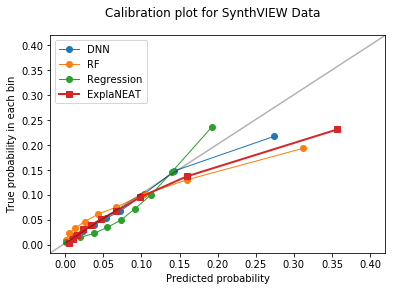

In [654]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()


# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black', alpha = 0.3)


# only these two lines are calibration curves
chartAlpha = 1
plt.plot(dnn_calib_x,dnn_calib_y, marker='o', linewidth=1, label='DNN', alpha=chartAlpha)
plt.plot(rf_calib_x,rf_calib_y, marker='o', linewidth=1, label='RF', alpha=chartAlpha)
plt.plot(reg_calib_x,reg_calib_y, marker='o', linewidth=1, label='Regression', alpha=chartAlpha)
plt.plot(eneat_calib_x,eneat_calib_y, marker='s', linewidth=2, label='ExplaNEAT', alpha=chartAlpha)
plt.plot([.4], [.4], marker='x', alpha=0)

transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for SynthVIEW Data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()


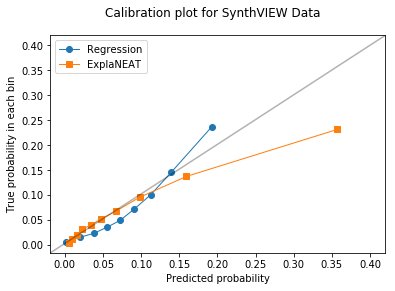

In [937]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()


# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black', alpha = 0.3)


# only these two lines are calibration curves
# plt.plot(dnn_calib_x,dnn_calib_y, marker='o', linewidth=1, label='DNN')
# plt.plot(rf_calib_x,rf_calib_y, marker='o', linewidth=1, label='RF')
plt.plot(reg_calib_x,reg_calib_y, marker='o', linewidth=1, label='Regression')
plt.plot(eneat_calib_x,eneat_calib_y, marker='s', linewidth=1, label='ExplaNEAT')
plt.plot([.4], [.4], marker='x', alpha=0)

transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for SynthVIEW Data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()


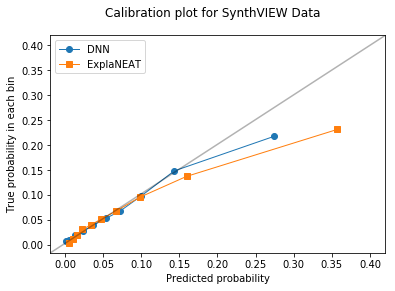

In [935]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()


# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black', alpha = 0.3)


# only these two lines are calibration curves
plt.plot(dnn_calib_x,dnn_calib_y, marker='o', linewidth=1, label='DNN')
# plt.plot(rf_calib_x,rf_calib_y, marker='o', linewidth=1, label='RF')
# plt.plot(reg_calib_x,reg_calib_y, marker='o', linewidth=1, label='Regression')
plt.plot(eneat_calib_x,eneat_calib_y, marker='s', linewidth=1, label='ExplaNEAT')
plt.plot([.4], [.4], marker='x', alpha=0)

transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for SynthVIEW Data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()


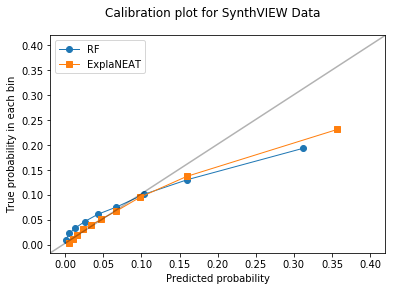

In [936]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()


# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black', alpha = 0.3)


# only these two lines are calibration curves
# plt.plot(dnn_calib_x,dnn_calib_y, marker='o', linewidth=1, label='DNN')
plt.plot(rf_calib_x,rf_calib_y, marker='o', linewidth=1, label='RF')
# plt.plot(reg_calib_x,reg_calib_y, marker='o', linewidth=1, label='Regression')
plt.plot(eneat_calib_x,eneat_calib_y, marker='s', linewidth=1, label='ExplaNEAT')
plt.plot([.4], [.4], marker='x', alpha=0)

transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for SynthVIEW Data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()


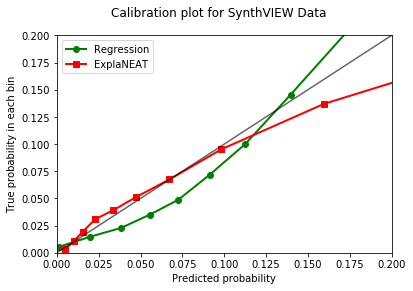

In [655]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()


# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black', alpha = 0.6)


# only these two lines are calibration curves
# plt.plot(dnn_calib_x,dnn_calib_y, marker='o', linewidth=1, label='DNN')
# plt.plot(rf_calib_x,rf_calib_y, marker='o', linewidth=1, label='RF')
plt.plot(reg_calib_x,reg_calib_y, marker='o', linewidth=2, color='green', label='Regression')
plt.plot(eneat_calib_x,eneat_calib_y, marker='s', linewidth=2, color='red', label='ExplaNEAT')
plt.plot([.4], [.4], marker='x', alpha=0)

transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for SynthVIEW Data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.xlim(0, 0.2)
plt.ylim(0, 0.2)
plt.legend()
plt.show()


In [873]:
ancestry

{46: {1728: 4.499532699584961, 1807: 4.506730079650879},
 45: {1728: 4.499532699584961},
 44: {1728: 4.499532699584961, 1553: 4.490467071533203},
 43: {1553: 4.490467071533203},
 42: {1553: 4.490467071533203},
 41: {1553: 4.490467071533203},
 40: {1553: 4.490467071533203, 1476: 4.4726152420043945},
 39: {1432: 4.472578048706055, 1476: 4.4726152420043945},
 38: {1432: 4.472578048706055,
  1434: 4.4699602127075195,
  1476: 4.4726152420043945},
 37: {1391: 4.469257831573486,
  1393: 4.45110559463501,
  1432: 4.472578048706055,
  1434: 4.4699602127075195},
 36: {1345: 4.4322123527526855,
  1393: 4.45110559463501,
  1182: 4.450186729431152,
  1391: 4.469257831573486},
 35: {1345: 4.4322123527526855,
  1221: 4.4322123527526855,
  1182: 4.450186729431152},
 34: {1221: 4.4322123527526855, 1182: 4.450186729431152},
 33: {1221: 4.4322123527526855, 1182: 4.450186729431152},
 32: {1182: 4.450186729431152,
  1221: 4.4322123527526855,
  1094: 4.429618835449219},
 31: {1137: 4.429514408111572,
  1182

In [932]:
ancestry_df = []
for k, v in ancestry.items():
    
    ancestry_df.append([k, max(v.values())])
print(ancestry_df)
ancestry_df.reverse()
ancestry_df = pd.DataFrame(ancestry_df, columns=['generation', 'fitness'])

[[46, 4.506730079650879], [45, 4.499532699584961], [44, 4.499532699584961], [43, 4.490467071533203], [42, 4.490467071533203], [41, 4.490467071533203], [40, 4.490467071533203], [39, 4.4726152420043945], [38, 4.4726152420043945], [37, 4.472578048706055], [36, 4.469257831573486], [35, 4.450186729431152], [34, 4.450186729431152], [33, 4.450186729431152], [32, 4.450186729431152], [31, 4.450186729431152], [30, 4.429618835449219], [29, 4.429618835449219], [28, 4.427045822143555], [27, 4.427045822143555], [26, 4.418888568878174], [25, 4.418888568878174], [24, 4.418888568878174], [23, 4.418888568878174], [22, 4.3699822425842285], [21, 4.36884069442749], [20, 4.36884069442749], [19, 4.36884069442749], [18, 4.362235069274902], [17, 4.362235069274902], [16, 4.362235069274902], [15, 4.362235069274902], [14, 4.326071262359619], [13, 4.237375736236572], [12, 4.237375736236572], [11, 4.2016520500183105], [10, 4.2016520500183105], [9, 4.14736795425415], [8, 4.14736795425415], [7, 3.859783887863159], [6

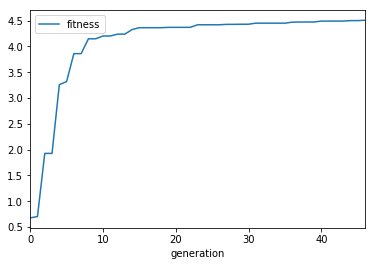

In [894]:
ancestry_df.plot(x='generation', y='fitness')

In [895]:
ancestry_df

,generation,fitness
0,0,0.676790
1,1,0.704087
2,2,1.926744
3,3,1.926744
4,4,3.258773
5,5,3.318857
6,6,3.859784
7,7,3.859784
8,8,4.147368
9,9,4.147368


In [898]:
print('generation 3, ancestor 112')
print(ancestors[112])

generation 3, ancestor 112
Key: 112
Fitness: 1.9267442226409912
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.326330304145813, response=1.0, activation=sigmoid, aggregation=sum)
	33 DefaultNodeGene(key=33, bias=0.9142535924911499, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-6, 0), weight=0.13443872332572937, enabled=True)
	DefaultConnectionGene(key=(-4, 0), weight=0.703231930732727, enabled=True)
	DefaultConnectionGene(key=(-3, 0), weight=-0.648514986038208, enabled=False)
	DefaultConnectionGene(key=(-3, 33), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(-2, 0), weight=0.22984474897384644, enabled=True)
	DefaultConnectionGene(key=(-1, 0), weight=0.038452208042144775, enabled=True)
	DefaultConnectionGene(key=(33, 0), weight=-0.648514986038208, enabled=True)


In [901]:
print('generation 7, ancestor 262')
print(ancestry[7])
print(ancestors[262])

generation 7, ancestor 262
{290: 3.503051280975342, 262: 3.859783887863159}
Key: 262
Fitness: 3.859783887863159
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.326330304145813, response=1.0, activation=sigmoid, aggregation=sum)
	33 DefaultNodeGene(key=33, bias=0.9142535924911499, response=1.0, activation=sigmoid, aggregation=sum)
	84 DefaultNodeGene(key=84, bias=0.25485798716545105, response=1.0, activation=sigmoid, aggregation=sum)
	103 DefaultNodeGene(key=103, bias=1.0926134586334229, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-6, 0), weight=0.13443872332572937, enabled=False)
	DefaultConnectionGene(key=(-6, 103), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(-2, 0), weight=0.22984474897384644, enabled=True)
	DefaultConnectionGene(key=(-1, 0), weight=0.038452208042144775, enabled=False)
	DefaultConnectionGene(key=(-1, 84), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(33, 0), weight=-0.648514986038208, enabled=True)
	DefaultCo

In [905]:
print('generation 9, ancestor 331')
print(ancestry[9])
print(ancestors[331])

generation 9, ancestor 262
{331: 4.14736795425415, 359: 4.14736795425415}
Key: 331
Fitness: 4.14736795425415
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.326330304145813, response=1.0, activation=sigmoid, aggregation=sum)
	33 DefaultNodeGene(key=33, bias=0.9142535924911499, response=1.0, activation=sigmoid, aggregation=sum)
	84 DefaultNodeGene(key=84, bias=0.25485798716545105, response=1.0, activation=sigmoid, aggregation=sum)
	103 DefaultNodeGene(key=103, bias=1.0926134586334229, response=1.0, activation=sigmoid, aggregation=sum)
	137 DefaultNodeGene(key=137, bias=0.7891878485679626, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-6, 0), weight=0.13443872332572937, enabled=False)
	DefaultConnectionGene(key=(-6, 103), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(-6, 137), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(-2, 0), weight=0.22984474897384644, enabled=True)
	DefaultConnectionGene(key=(-1, 0), weight=0.038452208042144775

In [907]:
print('generation 11, ancestor 428')
print(ancestry[11])
print(ancestors[428])

generation 11, ancestor 428
{395: 4.2016520500183105, 428: 4.2016520500183105}
Key: 428
Fitness: 4.2016520500183105
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.326330304145813, response=1.0, activation=sigmoid, aggregation=sum)
	33 DefaultNodeGene(key=33, bias=0.9142535924911499, response=1.0, activation=sigmoid, aggregation=sum)
	84 DefaultNodeGene(key=84, bias=0.25485798716545105, response=1.0, activation=sigmoid, aggregation=sum)
	103 DefaultNodeGene(key=103, bias=1.0926134586334229, response=1.0, activation=sigmoid, aggregation=sum)
	137 DefaultNodeGene(key=137, bias=0.7891878485679626, response=1.0, activation=sigmoid, aggregation=sum)
	173 DefaultNodeGene(key=173, bias=0.10554897785186768, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-6, 0), weight=0.13443872332572937, enabled=False)
	DefaultConnectionGene(key=(-6, 103), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(-6, 137), weight=1.0, enabled=True)
	DefaultConnectionGene(key=

In [911]:
print('generation 13, ancestor 465')
print(ancestry[13])
print(ancestors[465])

generation 13, ancestor 465
{465: 4.237375736236572, 395: 4.2016520500183105, 500: 4.237362384796143}
Key: 465
Fitness: 4.237375736236572
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.326330304145813, response=1.0, activation=sigmoid, aggregation=sum)
	33 DefaultNodeGene(key=33, bias=0.9142535924911499, response=1.0, activation=sigmoid, aggregation=sum)
	84 DefaultNodeGene(key=84, bias=0.25485798716545105, response=1.0, activation=sigmoid, aggregation=sum)
	103 DefaultNodeGene(key=103, bias=1.0926134586334229, response=1.0, activation=sigmoid, aggregation=sum)
	137 DefaultNodeGene(key=137, bias=0.7891878485679626, response=1.0, activation=sigmoid, aggregation=sum)
	173 DefaultNodeGene(key=173, bias=0.10554897785186768, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-6, 0), weight=0.13443872332572937, enabled=False)
	DefaultConnectionGene(key=(-6, 103), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(-6, 137), weight=1.0, enabled=True)
	Defa

In [924]:
ancestry_df[13:40]

,generation,fitness
13,13,4.237376
14,14,4.326071
15,15,4.362235
16,16,4.362235
17,17,4.362235
18,18,4.362235
19,19,4.368841
20,20,4.368841
21,21,4.368841
22,22,4.369982


In [923]:
print('generation 23, ancestor 852')
print(ancestry[23])
print(ancestors[855])

generation 23, ancestor 852
{817: 4.3699822425842285, 852: 4.4085493087768555, 709: 4.36884069442749, 855: 4.418888568878174}
Key: 855
Fitness: 4.418888568878174
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.326330304145813, response=1.0, activation=sigmoid, aggregation=sum)
	33 DefaultNodeGene(key=33, bias=0.9142535924911499, response=1.0, activation=sigmoid, aggregation=sum)
	84 DefaultNodeGene(key=84, bias=0.25485798716545105, response=1.0, activation=sigmoid, aggregation=sum)
	103 DefaultNodeGene(key=103, bias=1.0926134586334229, response=1.0, activation=sigmoid, aggregation=sum)
	137 DefaultNodeGene(key=137, bias=0.7891878485679626, response=1.0, activation=sigmoid, aggregation=sum)
	173 DefaultNodeGene(key=173, bias=0.10554897785186768, response=1.0, activation=sigmoid, aggregation=sum)
	324 DefaultNodeGene(key=324, bias=-1.390433669090271, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-6, 103), weight=1.0, enabled=True)
	DefaultConnection

In [931]:
print('generation 27, ancestor 1017')
print(ancestry[27])
print(ancestors[1017])

generation 27, ancestor 1017
{1017: 4.427045822143555, 933: 4.418888568878174, 855: 4.418888568878174}
Key: 1017
Fitness: 4.427045822143555
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.326330304145813, response=1.0, activation=sigmoid, aggregation=sum)
	33 DefaultNodeGene(key=33, bias=0.9142535924911499, response=1.0, activation=sigmoid, aggregation=sum)
	84 DefaultNodeGene(key=84, bias=0.25485798716545105, response=1.0, activation=sigmoid, aggregation=sum)
	103 DefaultNodeGene(key=103, bias=1.0926134586334229, response=1.0, activation=sigmoid, aggregation=sum)
	137 DefaultNodeGene(key=137, bias=0.7891878485679626, response=1.0, activation=sigmoid, aggregation=sum)
	173 DefaultNodeGene(key=173, bias=0.10554897785186768, response=1.0, activation=sigmoid, aggregation=sum)
	324 DefaultNodeGene(key=324, bias=-1.390433669090271, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-6, 103), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(-6, 137), we

In [922]:
print('generation 35, ancestor 1182')
print(ancestry[35])
print(ancestors[1182])

generation 35, ancestor 1182
{1345: 4.4322123527526855, 1221: 4.4322123527526855, 1182: 4.450186729431152}
Key: 1182
Fitness: 4.450186729431152
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.326330304145813, response=1.0, activation=sigmoid, aggregation=sum)
	33 DefaultNodeGene(key=33, bias=0.9142535924911499, response=1.0, activation=sigmoid, aggregation=sum)
	84 DefaultNodeGene(key=84, bias=0.25485798716545105, response=1.0, activation=sigmoid, aggregation=sum)
	103 DefaultNodeGene(key=103, bias=1.0926134586334229, response=1.0, activation=sigmoid, aggregation=sum)
	137 DefaultNodeGene(key=137, bias=0.7891878485679626, response=1.0, activation=sigmoid, aggregation=sum)
	173 DefaultNodeGene(key=173, bias=0.10554897785186768, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-6, 103), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(-6, 137), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(-6, 173), weight=1.0, enabled=False)
	DefaultConne